In [ ]:
#shared code from:
#https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920
#and 
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
!pip3 install spacy
!pip3 install gensim 
!pip3 install pyLDAvis
!python -m spacy download en_core_web_sm 

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [368]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sbgas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [369]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [370]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'rt', 'http', 'co', 'amp', 'https', 'nuclear', 's', "thats", 'energy', 'power', 'plant']) #"thats" is a bug in gensim.lemmatization that leaves behind the "s". 

### define df for total tweet bank 

In [529]:
# All tweets without demo data
df = pd.read_csv('Total_11-23-20.csv', index_col=0, dtype={"user_id":str})
#df.head(2)

### get clustered users

In [530]:
# All tweets with demo data 
df_cluster = pd.read_csv('C:/Users/sbgas/OneDrive/Desktop/cluster.csv', index_col=0, dtype={"user_id":str})
df_cluster.head(2)

,screen_name,user_id,user_description,user_follower_count,verified,City,State,Country,gender,age,org,cluster
0,prageru,41160276.0,Free Videos. Free Minds.,563593.0,True,Los Angeles,CA,USA,NaN,NaN,True,2
1,GovNuclear,1.1000641565045432e+18,Making nuclear cool again 😎. Advancing new tec...,12137.0,True,DC,MD,USA,NaN,NaN,True,2


In [531]:
#specify cluster ## 
df_cluster = df_cluster[df_cluster['cluster']==4]
df_cluster.cluster.value_counts()

4    1488
Name: cluster, dtype: int64

In [532]:
import numpy as np
np.mean(df_cluster['user_follower_count']), np.std(df_cluster['user_follower_count']) , np.median(df_cluster['user_follower_count'])

(2786.1276881720432, 26579.02988272042, 543.0)

In [533]:
df_cluster['verified'].value_counts()

False    1456
True       32
Name: verified, dtype: int64

In [534]:
df_cluster['gender'].value_counts()

male      1285
female      78
Name: gender, dtype: int64

In [535]:
df_cluster['age'].value_counts()

>=40     1169
30-39     130
<=18       55
19-29       9
Name: age, dtype: int64

In [536]:
df_cluster['org'].value_counts()

False    1363
True       37
Name: org, dtype: int64

### Filter tweet bank on this cluster 

In [537]:
#df indexed where scree_name value is in the screen name series of the df_cluster
df = df[df['screen_name'].isin(df_cluster['screen_name'])]
len(df)

4754

### Clean text and tokenize

In [538]:
# Convert to list 
data = df.text.values.tolist()  
# Remove @ addresses 
data = [re.sub(r'\S*@\S*\s?', '', sent) for sent in data]  
# Remove web addresses
data = [re.sub(r'https?://\S+', '', sent) for sent in data]  
# Remove new line characters 
data = [re.sub(r'\s+', ' ', sent) for sent in data]  
# Remove single quotes 
data = [re.sub("\'", "", sent) for sent in data]  
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),min_len=3, max_len=15, deacc=True))            #deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[34:35])

[['this', 'important', 'the', 'ardp', 'selection', 'decision', 'could', 'make', 'break', 'americas', 'nuclear', 'future', 'should', 'big', 'and', 'pick', 'truly', 'advanced', 'design', 'that', 'can', 'integrate', 'into', 'tomorrows', 'utility', 'grids', 'the', 'and', 'abroad', 'have', 'get', 'this', 'right']]


### Making bigrams and trigrams

In [539]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold, fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Fet a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# trigram example
print(trigram_mod[bigram_mod[data_words[34]]])

['this', 'important', 'the', 'ardp', 'selection', 'decision', 'could', 'make', 'break', 'americas', 'nuclear', 'future', 'should', 'big', 'and', 'pick', 'truly', 'advanced', 'design', 'that', 'can', 'integrate', 'into', 'tomorrows', 'utility', 'grids', 'the', 'and', 'abroad', 'have', 'get', 'this', 'right']


In [540]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [541]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Initialize spacy English model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[34:35])

[['important', 'selection', 'decision', 'could', 'make', 'break', 'americas', 'future', 'big', 'pick', 'truly', 'advanced', 'design', 'integrate', 'tomorrow', 'utility', 'grid', 'abroad', 'get', 'right']]


In [542]:
print(len(corpora.Dictionary(data_lemmatized)))

6590


In [543]:
# collect statistics about all tokens
id2word = corpora.Dictionary(data_lemmatized) 

# remove words that appear only once
once_ids = [tokenid for tokenid, docfreq in id2word.dfs.items() if docfreq == 1]

id2word.filter_tokens(once_ids)# remove stop words and words that appear only once
id2word.compactify()# remove gaps in id sequence after words that were removed

In [544]:
print(len(id2word))

3614


In [545]:
# Create Corpus 
texts = data_lemmatized  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  #words that don't appear in the id2word will not appear in corpus

In [546]:
#Create the Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=110,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

### Find the maximum coherence score 

In [400]:
def coherence_values_computation(dictionary, corpus, texts, limit, start=20, step=10):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [401]:
model_list, coherence_values = coherence_values_computation(id2word, corpus, texts, 120)

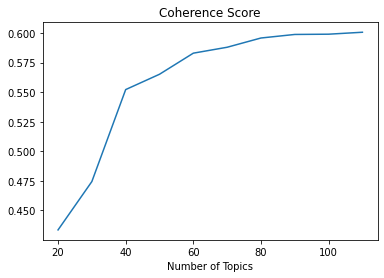

In [402]:
x = range(20, 120, 10)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
#plt.ylabel("Coherence score")
plt.title("Coherence Score")
#plt.legend(("Coherence"), loc='lower right')
plt.show()

### Evaluations of topic model
- The lower the perplexity better the model.
- The higher the topic coherence, the topic is more human interpretable.

In [547]:
#number of topics 
n=9
print(x[n])

# Compute Perplexity
optimal_model = lda_model #model_list[n] 

110


In [528]:
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -62.17642774341953

Coherence Score:  0.6587066680315372


### Visualization

In [548]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='mmds')
vis

C:\Users\sbgas\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
67     0.168928  0.553873       1        1  5.610566
48    -0.360880  0.420618       2        1  4.133166
82    -0.275670  0.473564       3        1  4.015646
46     0.343623 -0.417648       4        1  3.813705
100    0.544463  0.198625       5        1  3.363431
20    -0.455239 -0.291069       6        1  3.288759
68    -0.034423 -0.566225       7        1  3.282115
98    -0.524489 -0.134794       8        1  3.275962
51    -0.540375  0.061333       9        1  3.211917
79    -0.496244  0.180943      10        1  2.878327
85     0.458243 -0.282528      11        1  2.657090
73     0.023728 -0.526537      12        1  2.654957
95     0.528560 -0.034109      13        1  2.624233
2      0.190253 -0.471569      14        1  2.251031
105   -0.499616 -0.000010      15        1  2.239995
52    -0.023507  0.497010      16        1  2.100978
107    0.346068  0.355364      17        1  2.050324
55     0.400681 -0.246106      18        1  1.914125
40     0.252793  0.391166      19        1  1.858067
16     0.485322 -0.096989      20        1  1.775175
45    -0.348300 -0.359516      21        1  1.752357
108   -0.392543  0.278142      22        1  1.747927
106    0.216799  0.428729      23        1  1.615549
25    -0.446994  0.180808      24        1  1.615242
29    -0.453138 -0.053599      25        1  1.552466
37     0.375719  0.277306      26        1  1.544680
54    -0.096789  0.498809      27        1  1.532150
96    -0.211294  0.405961      28        1  1.487959
90     0.419863  0.179101      29        1  1.455623
22     0.121207  0.438941      30        1  1.437609
...         ...       ...     ...      ...       ...
72    -0.007359 -0.005715      81        1  0.067487
71    -0.007359 -0.005715      82        1  0.067487
69    -0.007359 -0.005715      83        1  0.067487
80    -0.007359 -0.005715      84        1  0.067487
66    -0.007359 -0.005715      85        1  0.067487
65    -0.007359 -0.005715      86        1  0.067487
64    -0.007359 -0.005715      87        1  0.067487
63    -0.007359 -0.005715      88        1  0.067487
62    -0.007359 -0.005715      89        1  0.067487
59    -0.007359 -0.005715      90        1  0.067487
58    -0.007359 -0.005715      91        1  0.067487
57    -0.007359 -0.005715      92        1  0.067487
56    -0.007359 -0.005715      93        1  0.067487
83    -0.007359 -0.005715      94        1  0.067487
34    -0.007359 -0.005715      95        1  0.067487
53    -0.007359 -0.005715      96        1  0.067487
84    -0.007359 -0.005715      97        1  0.067487
86    -0.007359 -0.005715      98        1  0.067487
49    -0.007359 -0.005715      99        1  0.067487
47    -0.007359 -0.005715     100        1  0.067487
88    -0.007359 -0.005715     101        1  0.067487
89    -0.007359 -0.005715     102        1  0.067487
44    -0.007359 -0.005715     103        1  0.067487
42    -0.007359 -0.005715     104        1  0.067487
41    -0.007359 -0.005715     105        1  0.067487
92    -0.007359 -0.005715     106        1  0.067487
39    -0.007359 -0.005715     107        1  0.067487
75    -0.007359 -0.005715     108        1  0.067487
93    -0.007359 -0.005715     109        1  0.067487
0     -0.007359 -0.005715     110        1  0.067487

[110 rows x 5 columns], topic_info=      Category         Freq                  Term        Total  loglift  \
term                                                                      
118    Default  1094.000000               reactor  1094.000000  30.0000   
17     Default  1227.000000                 waste  1227.000000  29.0000   
117    Default   494.000000                  make   494.000000  28.0000   
137    Default   622.000000                weapon   622.000000  27.0000   
196    Default   541.000000                  year   541.000000  26.0000   
19     Default   615.000000                 plant   615.000000  25.00

### Add Primary Topic to tweet dataframe and Save to CSV

In [549]:
#build data list from corpus 
data = [] 
#bag of word vecto count doc as input
for i in corpus:
    data.append(max(optimal_model[i][0], key=lambda x: x[1])[0]) #select the topic that has the highest probability for each tweet in corpus

In [550]:
df['topic'] = data
#df.head(2)

,time_retrieved,text,created_at,favorite_count,retweet_count,place,coordinates,user_id,screen_name,user_description,user_follower_count,verified,user_location,City,State,Country,topic
status_id,,,,,,,,,,,,,,,,,
1328441087195709440,2020-11-16 21:14,Multiply these by capacity factor (project spe...,2020-11-16 20:53:31,1.0,0.0,NaN,NaN,18457820,KarlAlexPauls,He/him. Agile Platform Lead Engineer🖥️ Ecomode...,1170.0,False,"Seattle, WA",Seattle,WA,USA,4
1328401191470997506,2020-11-16 21:14,Invest in public infrastructure and clean ener...,2020-11-16 18:14:59,8.0,2.0,NaN,NaN,18457820,KarlAlexPauls,He/him. Agile Platform Lead Engineer🖥️ Ecomode...,1170.0,False,"Seattle, WA",Seattle,WA,USA,68


In [551]:
for ind, topic in optimal_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(ind, topic))
    print()

Topic: 0 
Words: 0.000*"supporter" + 0.000*"century" + 0.000*"leaders_three_agencie" + 0.000*"abruptly_dumped" + 0.000*"fraction" + 0.000*"acre" + 0.000*"mistaken" + 0.000*"rock" + 0.000*"alive" + 0.000*"nervous"

Topic: 1 
Words: 0.000*"supporter" + 0.000*"century" + 0.000*"leaders_three_agencie" + 0.000*"abruptly_dumped" + 0.000*"fraction" + 0.000*"acre" + 0.000*"mistaken" + 0.000*"rock" + 0.000*"alive" + 0.000*"nervous"

Topic: 2 
Words: 0.299*"today" + 0.252*"support" + 0.216*"thing" + 0.135*"try" + 0.012*"thread" + 0.011*"ridiculous" + 0.006*"broad" + 0.000*"commission" + 0.000*"leaders_three_agencie" + 0.000*"nervous"

Topic: 3 
Words: 0.000*"supporter" + 0.000*"century" + 0.000*"leaders_three_agencie" + 0.000*"abruptly_dumped" + 0.000*"fraction" + 0.000*"acre" + 0.000*"mistaken" + 0.000*"rock" + 0.000*"alive" + 0.000*"nervous"

Topic: 4 
Words: 0.372*"project" + 0.300*"job" + 0.081*"hour" + 0.068*"note" + 0.034*"specific" + 0.000*"leaders_three_agencie" + 0.000*"abruptly_dumped"

In [ ]:
"""
Prominence from chart: 
1. Topic 5, "waste"
2. Topic 81, "reactor"
3. Topic 1, "use", "year"
4. Topic 10, "make", "future"
5. Topic 29, "want", "renewable"

7 is about technological innovation, 8 is about jobs/work, 13 was climate change, 14 was safety

"""

In [ ]:
"""
Cluster 0: Women over 30 
1: waste 56 (Waste)
2. weapon, deal 25 (Weapons)
3. build 93 (Construction)
4. new, facility 95 (Design)
5. even, country, likely, set, keep 13 (National Interests)
"""

In [ ]:
"""
Cluster 1: Males over 40, relatively many followers (median = 948) 
1. could, cost (potential problems)
2.want, stop (potential policies)
3. weapon, people (Weapons)
4.waste (Waste)
5.would, say (conjectures)
"""

In [ ]:
"""
Cluster 2: Organizations
1. reactor, advanced (Reactor Design)
2. new, future (The Future)
3. help, reduce (Climate Change)
4. today, industry (Org Events)
5. waste (Waste)
"""

In [ ]:
"""
Cluster 3: less than 40. Mostly Male. 
1. would year (Political Discussion)
2. know, need, work (News)
3. give, thing, watch (Techincal/Policy Debate)
4. go, see (Renewable Energy)
5. well, read, solution (Policy Debate)
"""

In [ ]:
"""
Cluster 4: male, over 40, relatively few followers (median=543)
1. waste, use (Waste)
2. trump (Politics)
3. new, plant (Design)
4. weapon (Weapons)
5. reactor (Reactor design)
"""

In [557]:
#save top n topic dataframes to CSV 
n = 100    #this is the LDA label for the topic
df[df['topic']== n].to_csv('./cluster 4/reactor_topic_tweets.csv')

### get primary words and their counts from each topic

In [318]:
pri_words = dict()
for topic in optimal_model.print_topics(10):
    pri_words[topic[0]] = [token.split('*')[1].replace('"', '') for token in topic[1].split(' + ')]
pri_words[5] #indexed on topic id

['waste',
 'know',
 'radioactive',
 'store',
 'far',
 'real',
 'safely',
 'management',
 'international',
 'disposal']

In [319]:
#dfs is the id:count
#id2word is the id:word
#this makes word_count_dict the word:count
word_count_dict = dict()
for tokenid, docfreq in id2word.dfs.items():
    word_count_dict[id2word[tokenid]] = docfreq

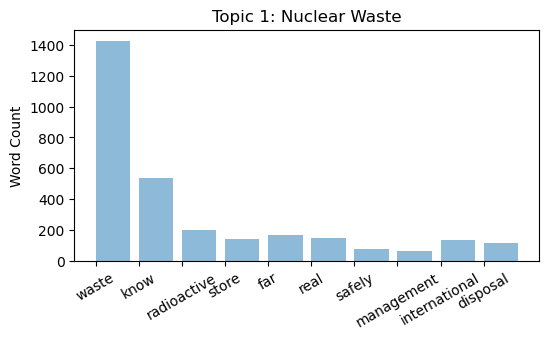

In [333]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
"""
1. Topic 5, "waste"
2. Topic 81, "reactor"
3. Topic 1, "use", "year"
4. Topic 10, "make", "future"
5. Topic 29, "want", "renewable"
"""
rot = 30 

x = pri_words[5] #indexed on topic id 
y = [word_count_dict[word] for word in x]

y_pos = np.arange(len(x))
plt.figure(figsize=(6,3))
plt.bar(y_pos, y, align='edge', alpha=0.5)
plt.xticks(y_pos, x, rotation=rot)
# fontsize=14)
plt.ylabel('Word Count')
plt.title('Topic 1: Nuclear Waste')

plt.show()

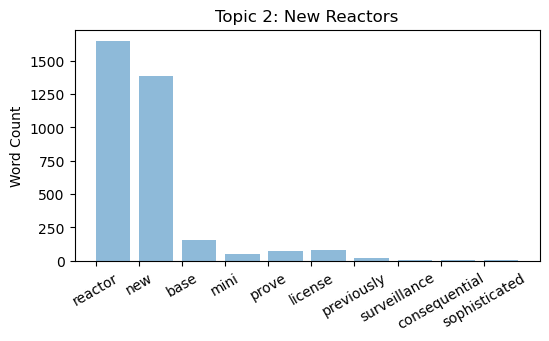

In [334]:
x = pri_words[81] #indexed on topic id 
y = [word_count_dict[word] for word in x]

y_pos = np.arange(len(x))
plt.figure(figsize=(6,3))
plt.bar(y_pos, y, align='edge', alpha=0.5)
plt.xticks(y_pos, x, rotation=rot)
# fontsize=14)
plt.ylabel('Word Count')
plt.title('Topic 2: New Reactors')

plt.show()

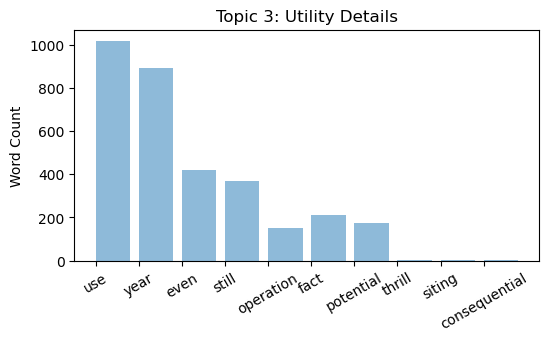

In [335]:
x = pri_words[1] #indexed on topic id 
y = [word_count_dict[word] for word in x]

y_pos = np.arange(len(x))
plt.figure(figsize=(6,3))
plt.bar(y_pos, y, align='edge', alpha=0.5)
plt.xticks(y_pos, x, rotation=rot)
# fontsize=14)
plt.ylabel('Word Count')
plt.title('Topic 3: Utility Details')

plt.show()

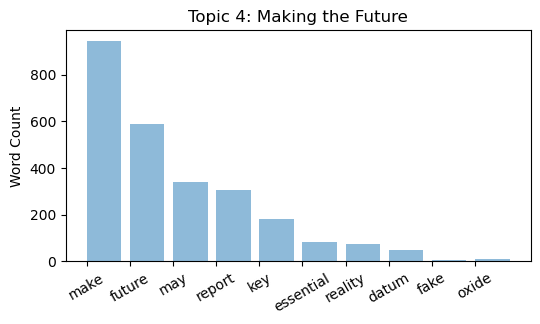

In [336]:
x = pri_words[10] #indexed on topic id 
y = [word_count_dict[word] for word in x]

y_pos = np.arange(len(x))
plt.figure(figsize=(6,3))
plt.bar(y_pos, y, align='edge', alpha=0.5)
plt.xticks(y_pos, x, rotation=rot)
# fontsize=14)
plt.ylabel('Word Count')
plt.title('Topic 4: Making the Future')

plt.show()

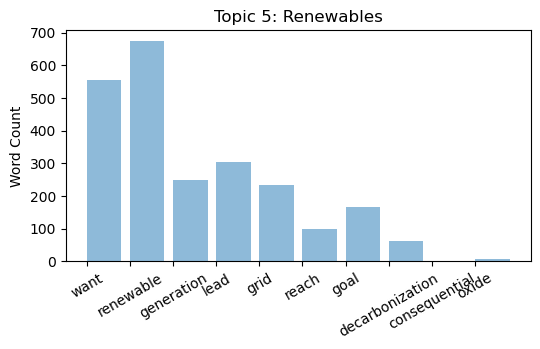

In [337]:
x = pri_words[29] #indexed on topic id 
y = [word_count_dict[word] for word in x]

y_pos = np.arange(len(x))
plt.figure(figsize=(6,3))
plt.bar(y_pos, y, align='edge', alpha=0.5)
plt.xticks(y_pos, x, rotation=rot)
# fontsize=14)
plt.ylabel('Word Count')
plt.title('Topic 5: Renewables')

plt.show()